# Explore Music Popularity Decay

### Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
from datetime import datetime, timedelta

### Data Imports

In [7]:
df_track = pd.read_csv('../data/track.csv')
df_album = pd.read_csv('../data/album.csv')
df_artist = pd.read_csv('../data/artist.csv')
df_rating = pd.read_csv('../data/rating.csv')
df_similar = pd.read_csv('../data/track_similarity.csv')

In [8]:
def get_artist_id(artist_name):
    return df_artist[df_artist['name'] == artist_name]['artist_id'].values[0]

def get_album_id(album_name):
    return df_album[df_album['name'] == album_name]['album_id'].values[0]

def get_track_id(track_name):
    return df_track[df_track['name'] == track_name]['track_id'].values[0]

# ====================================================

def get_all_tracks_by_artist(artist_id, only_id=False):
    return df_track[df_track['artist_id'] == artist_id] if not only_id else df_track[df_track['artist_id'] == artist_id]['track_id']

def get_all_tracks_by_album(album_id, only_id=False):
    return df_track[df_track['album_id'] == album_id] if not only_id else df_track[df_track['album_id'] == album_id]['track_id']

def get_all_albums_by_artist(artist_id, only_id=False):
    return df_album[df_album['artist_id'] == artist_id] if not only_id else df_album[df_album['artist_id'] == artist_id]['album_id']

# ====================================================

def convert_track_id_to_name(track_id):
    return df_track[df_track['track_id'] == track_id]['name'].values[0]

def convert_album_id_to_name(album_id):
    return df_album[df_album['album_id'] == album_id]['name'].values[0]

def convert_artist_id_to_name(artist_id):
    return df_artist[df_artist['artist_id'] == artist_id]['name'].values[0]

In [9]:
# Calculate the daily listeners of a track
def get_daily_views(track_id):

    ret = list()

    # filter the track
    track_data = df_rating[df_rating['track_id'] == track_id]
    track_data = track_data.reset_index(drop=True)

    # for each row, get the number of listeners
    for row in range(len(track_data)):
        spotify_listeners = track_data['no_of_listeners_spotify'][row]
        lastfm_listeners = track_data['no_of_listeners_lastfm'][row]

        # if the listeners are not available, set them to 0
        if np.isnan(spotify_listeners):
            spotify_listeners = 0
        if np.isnan(lastfm_listeners):
            lastfm_listeners = 0

        # if not available for both, skip
        if spotify_listeners == 0 and lastfm_listeners == 0:
            continue

        # get the day   
        day = track_data['date'][row]

        # append the total number of listeners
        ret.append((int(spotify_listeners + lastfm_listeners), day))

    return ret



In [14]:
def plot_daily_rating(daily_rating, track_name):
    # plot the daily listeners over time
    plt.plot([x[1] for x in daily_rating], [x[0] for x in daily_rating])
    plt.xlabel('Date')
    plt.ylabel('Number of Listeners')
    plt.title(f'Daily Listeners of {track_name}')

    # Set x-ticks to show only the first, center, and last dates
    x_labels = [daily_rating[0][1], daily_rating[len(daily_rating)//2][1], daily_rating[-1][1]]
    plt.xticks([0, len(daily_rating)//2, len(daily_rating)-1], x_labels)

    plt.show()

# make lambda function to get and plot the daily listeners of a track
get_and_plot_daily_rating = lambda track_name: plot_daily_rating(get_daily_views(get_track_id(track_name)), track_name)

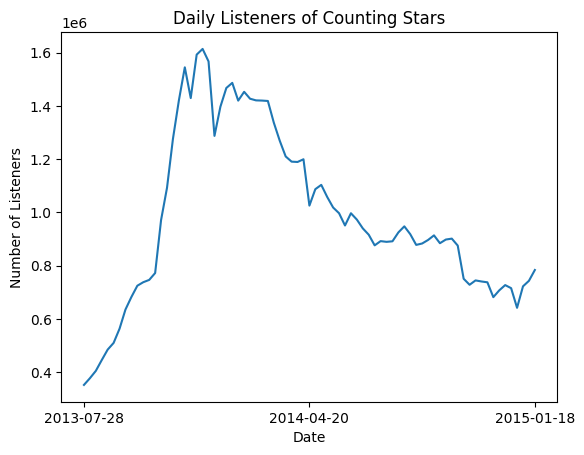

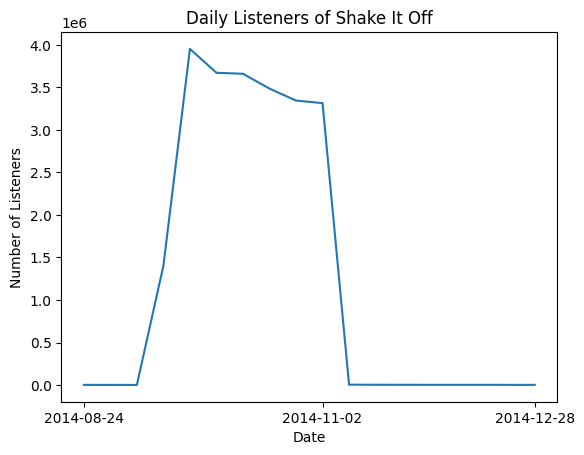

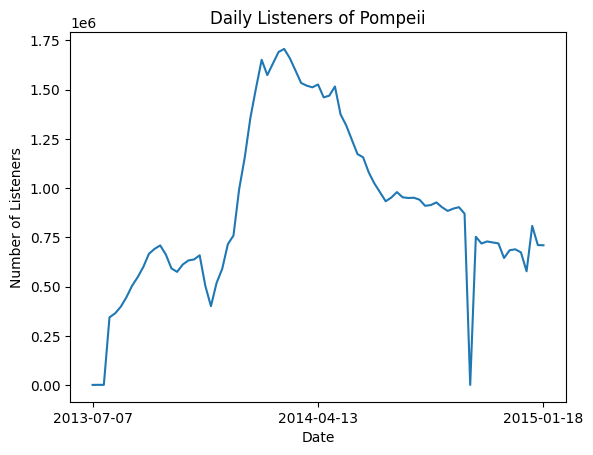

In [15]:
get_and_plot_daily_rating('Counting Stars')
get_and_plot_daily_rating('Shake It Off')
get_and_plot_daily_rating('Pompeii')

Number of tracks: 12
[[(3923, '2011-02-27'), (3978, '2011-03-06'), (3726, '2011-03-13'), (3226, '2011-03-20'), (3326, '2011-03-27'), (3330, '2011-04-03'), (3265, '2011-04-10'), (3397, '2011-04-17'), (4063, '2011-04-24'), (4116, '2011-05-01'), (3885, '2011-05-08'), (4345, '2011-05-15'), (4001, '2011-05-22'), (3879, '2011-05-29'), (3632, '2011-06-05'), (3477, '2011-06-12'), (3395, '2011-06-19'), (3372, '2011-06-26'), (3028, '2011-07-03'), (2963, '2011-07-10'), (3020, '2011-07-17'), (2724, '2011-07-24'), (2862, '2011-07-31'), (2721, '2011-08-07'), (2638, '2011-08-14'), (2744, '2011-08-21'), (2783, '2011-08-28'), (3557, '2011-09-04'), (3452, '2011-09-11'), (3249, '2011-09-18'), (3238, '2011-09-25'), (3123, '2011-10-02'), (3147, '2011-10-09'), (3019, '2011-10-16'), (2732, '2011-10-23'), (2704, '2011-10-30'), (2700, '2011-11-06'), (2847, '2011-11-13'), (3067, '2011-11-20'), (2794, '2011-11-27'), (3014, '2011-12-04'), (3130, '2011-12-11'), (3141, '2011-12-18'), (2839, '2011-12-25'), (3048, '2

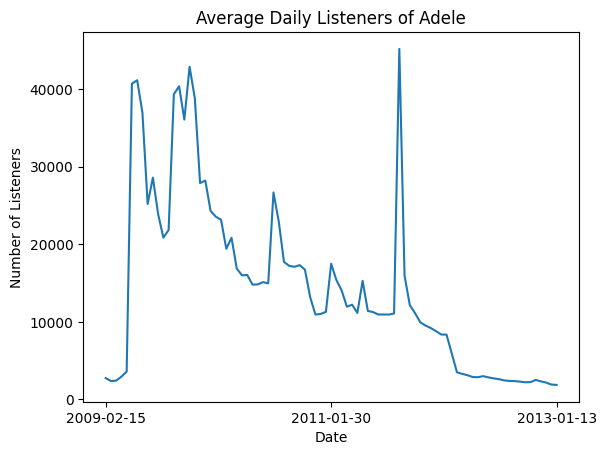

In [12]:
# function for overt-time listeners of a artist and plot it
def get_avg_daily_listeners(artist_id):
    # get all tracks by the artist
    tracks = get_all_tracks_by_artist(artist_id, only_id=True)

    # get the daily listeners of each track
    daily_listeners = [get_daily_views(track) for track in tracks]

    # remove empty daily listeners
    daily_listeners = [daily for daily in daily_listeners if daily]

    print('Number of tracks:', len(daily_listeners))

    print(daily_listeners)

    # get the limit dates
    lowest_date = min([daily[0][1] for daily in daily_listeners])
    highest_date = max([daily[-1][1] for daily in daily_listeners])

    # Parse the string dates into datetime objects
    start_date = datetime.strptime(lowest_date, '%Y-%m-%d')
    end_date = datetime.strptime(highest_date, '%Y-%m-%d')

    # List to store average daily listeners
    avg_daily_listeners = []

    # Iterate over all days between start_date and end_date
    current_date = start_date
    while current_date <= end_date:
        listeners = 0
        for daily in daily_listeners: 
            for count, listeners_date in daily:
                if listeners_date == str(current_date)[:10]:
                    listeners += count
                    
        avg_daily_listeners.append(listeners)
        current_date += timedelta(days=1)

    # ignore the days with no listeners
    avg_daily_listeners = [x for x in avg_daily_listeners if x != 0]


    # plot the daily listeners over time
    plt.plot(avg_daily_listeners)
    plt.xlabel('Date')
    plt.ylabel('Number of Listeners')
    plt.title(f'Average Daily Listeners of {convert_artist_id_to_name(artist_id)}')

    x_labels = [lowest_date, str(start_date + (end_date - start_date) // 2)[:10], highest_date]
    plt.xticks([0, len(avg_daily_listeners)//2, len(avg_daily_listeners)-1], x_labels)

    plt.show()

# make lambda function to get and plot the average daily listeners of an artist
get_and_plot_avg_daily_listeners = lambda artist_name: get_avg_daily_listeners(get_artist_id(artist_name))

get_and_plot_avg_daily_listeners('Adele')


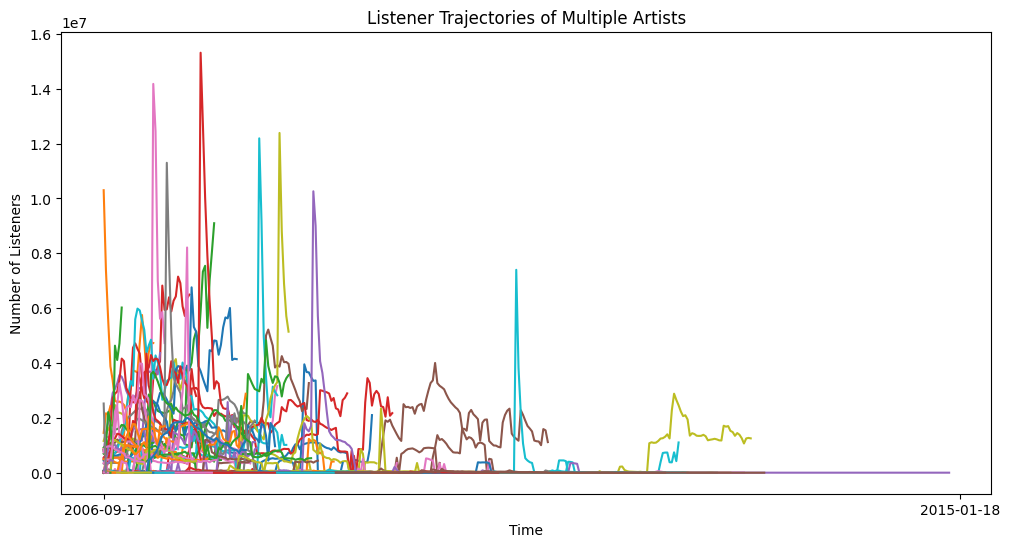

Top 20 artists with the most listeners ever:
Drake: 15310767 listeners on 2009-08-17
J. Cole: 14173544 listeners on 2013-05-20
Nicki Minaj: 12386420 listeners on 2011-02-14
One Direction: 12189735 listeners on 2012-05-26
Eminem: 11298436 listeners on 2009-06-14
Jay Z: 10299310 listeners on 2013-07-14
Daft Punk: 10259873 listeners on 2007-10-09
Ed Sheeran: 9095357 listeners on 2013-01-27
Various Artists: 8211248 listeners on 2013-07-23
Kanye West: 7397583 listeners on 2008-01-28
Sam Smith: 7149573 listeners on 2014-05-30
Ariana Grande: 6758775 listeners on 2013-06-06
Michael Buble: 6021857 listeners on 2013-12-16
Lorde: 5983734 listeners on 2013-07-15
Hozier: 5750829 listeners on 2014-08-27
Maroon 5: 5219134 listeners on 2007-07-25
Calvin Harris: 4833089 listeners on 2013-01-15
Meghan Trainor: 4365862 listeners on 2014-08-21
Miley Cyrus: 4344561 listeners on 2010-01-15
Iggy Azalea: 4289223 listeners on 2014-04-27


In [13]:
def get_avg_daily_listeners_all_artists(artist_ids):

    # Dictionary to store each artist's daily listeners
    artist_trajectories = {}

    top_20_artists = []

    total_lowest_date = None
    total_highest_date = None

    store_peak_days = {}

    # Iterate through each artist ID
    for artist_id in artist_ids:
        # get all tracks by the artist
        tracks = get_all_tracks_by_artist(artist_id, only_id=True)

        # get the daily listeners of each track
        daily_listeners = [get_daily_views(track) for track in tracks]

        # remove empty daily listeners
        daily_listeners = [daily for daily in daily_listeners if daily]

        if not daily_listeners:
            # print(f"No data available for artist ID {artist_id}")
            continue

        if len(daily_listeners) < 5:
            # print(f"Skipping artist {convert_artist_id_to_name(artist_id)} due to insufficient data")
            continue

        # print(f"Processing {convert_artist_id_to_name(artist_id)}, Number of tracks: {len(daily_listeners)}")

        # get the limit dates
        lowest_date = min([daily[0][1] for daily in daily_listeners])
        highest_date = max([daily[-1][1] for daily in daily_listeners])

        if total_lowest_date is None or datetime.strptime(lowest_date, '%Y-%m-%d') < total_lowest_date:
            total_lowest_date = datetime.strptime(lowest_date, '%Y-%m-%d')

        if total_highest_date is None or datetime.strptime(highest_date, '%Y-%m-%d') > total_highest_date:
            total_highest_date = datetime.strptime(highest_date, '%Y-%m-%d')

        # Parse the string dates into datetime objects
        start_date = datetime.strptime(lowest_date, '%Y-%m-%d')
        end_date = datetime.strptime(highest_date, '%Y-%m-%d')

        # List to store average daily listeners
        avg_daily_listeners = []

        # Iterate over all days between start_date and end_date
        current_date = start_date
        while current_date <= end_date:
            listeners = 0
            for daily in daily_listeners:
                for count, listeners_date in daily:
                    if listeners_date == str(current_date)[:10]:
                        listeners += count

            avg_daily_listeners.append(listeners)
            current_date += timedelta(days=1)

        # ignore the days with no listeners
        avg_daily_listeners = [x for x in avg_daily_listeners if x != 0]

        # Add trajectory to dictionary
        artist_trajectories[convert_artist_id_to_name(artist_id)] = avg_daily_listeners

        # get their peak day
        peak_day = max(avg_daily_listeners)
        peak_day_index = avg_daily_listeners.index(peak_day)
        peak_date = start_date + timedelta(days=peak_day_index)

        store_peak_days[convert_artist_id_to_name(artist_id)] = (peak_date, peak_day)

    # Plot each artist's trajectory
    plt.figure(figsize=(12, 6))

    for artist_name, listeners in artist_trajectories.items():
        plt.plot(listeners, label=artist_name)

    plt.xlabel('Time')
    plt.ylabel('Number of Listeners')
    plt.title('Listener Trajectories of Multiple Artists')

    x_labels = [str(total_lowest_date)[:10], str(total_highest_date)[:10]]
    
    # place on at the beginning and the other at the end end of the x-axis
    plt.xticks([0, len(avg_daily_listeners)*190], x_labels) # programming is the art of not knowing what you're doing...

    # plt.legend()
    plt.show()

    for artist_name, listeners in artist_trajectories.items():
        top_20_artists.append((artist_name, max(listeners)))

    top_20_artists = sorted(top_20_artists, key=lambda x: x[1], reverse=True)[:20]

    print("Top 20 artists with the most listeners ever:")
    for artist, _ in top_20_artists:
        print(f"{artist}: {store_peak_days[artist][1]} listeners on {store_peak_days[artist][0].strftime('%Y-%m-%d')}")

# Example usage with a list of artist IDs
all_artists_ids = [artist for artist in df_artist['artist_id']]
get_avg_daily_listeners_all_artists(all_artists_ids)

According to GPT:

Drake: 15,310,767 listeners on August 17, 2009
	•	Release Context: Drake’s third mixtape, So Far Gone, was released in February 2009, featuring hits like “Best I Ever Had.” The mixtape’s success significantly boosted his popularity throughout 2009.

J. Cole: 14,173,544 listeners on May 20, 2013
	•	Release Context: J. Cole’s second studio album, Born Sinner, was released on June 18, 2013. The lead-up to this release, including singles like “Power Trip” featuring Miguel, likely increased his listener count in May 2013.

Nicki Minaj: 12,386,420 listeners on February 14, 2011
	•	Release Context: Nicki Minaj’s debut album, Pink Friday, was released in November 2010, featuring hits like “Super Bass.” Her rising popularity during this period aligns with the February 2011 peak.

One Direction: 12,189,735 listeners on May 26, 2012
	•	Release Context: One Direction’s debut album, Up All Night, was released in November 2011, with singles like “What Makes You Beautiful” gaining massive popularity into 2012.

Eminem: 11,298,436 listeners on June 14, 2009
	•	Release Context: Eminem’s album, Relapse, was released in May 2009, marking his return to music after a hiatus. The album’s release likely contributed to the June 2009 listener peak.

Jay-Z: 10,299,310 listeners on July 14, 2013
	•	Release Context: Jay-Z’s album, Magna Carta Holy Grail, was released on July 4, 2013. The album’s release and promotion likely led to the mid-July listener peak.

Daft Punk: 10,259,873 listeners on October 9, 2007
	•	Release Context: Daft Punk’s live album, Alive 2007, was recorded in June 2007 and released in November 2007. The anticipation and their live performances during this period may have increased their listener count.

Ed Sheeran: 9,095,357 listeners on January 27, 2013
	•	Release Context: Ed Sheeran’s debut album, +, was released in September 2011. His growing popularity and touring in 2012 likely contributed to the listener peak in early 2013.

Kanye West: 7,397,583 listeners on January 28, 2008
	•	Release Context: Kanye West’s album, Graduation, was released in September 2007, featuring hits like “Stronger.” The sustained popularity of the album likely led to the listener peak in early 2008.

Sam Smith: 7,149,573 listeners on May 30, 2014
	•	Release Context: Sam Smith’s debut album, In the Lonely Hour, was released in May 2014, featuring singles like “Stay With Me.” The album’s release aligns with the listener peak.

Ariana Grande: 6,758,775 listeners on June 6, 2013
	•	Release Context: Ariana Grande’s debut single, “The Way,” was released in March 2013, gaining significant popularity and leading up to her debut album, Yours Truly, in August 2013.

Michael Bublé: 6,021,857 listeners on December 16, 2013
	•	Release Context: Michael Bublé’s album, To Be Loved, was released in April 2013. His music often sees a resurgence during the holiday season, which may explain the December listener peak.

Lorde: 5,983,734 listeners on July 15, 2013
	•	Release Context: Lorde’s debut single, “Royals,” was released in March 2013, gaining international acclaim and leading up to her debut album, Pure Heroine, in September 2013.

Hozier: 5,750,829 listeners on August 27, 2014
	•	Release Context: Hozier’s debut single, “Take Me to Church,” was released in 2013 and gained significant popularity throughout 2014, leading up to his debut album in September 2014.

Maroon 5: 5,219,134 listeners on July 25, 2007
	•	Release Context: Maroon 5’s album, It Won’t Be Soon Before Long, was released in May 2007, featuring hits like “Makes Me Wonder.” The album’s success likely led to the July 2007 listener peak.

Calvin Harris: 4,833,089 listeners on January 15, 2013
	•	Release Context: Calvin Harris’s album, 18 Months, was released in October 2012, featuring multiple hit singles that remained popular into 2013.

Meghan Trainor: 4,365,862 listeners on August 21, 2014
	•	Release Context: Meghan Trainor’s debut single, “All About That Bass,” was released in June 2014 and became a global hit, leading to the August listener peak.

Miley Cyrus: 4,344,561 listeners on January 15, 2010
	•	Release Context: Miley Cyrus’s EP, The Time of Our Lives, was released in August 2009, featuring the hit “Party in the U.S.A.” The sustained popularity likely contributed to the January 2010 peak.



Based on the release timeline and the listener peaks, the artists whose peaks don’t strongly align with specific album or single releases include:
	
	1.	Daft Punk (October 9, 2007)
	•	Their peak occurs slightly before the release of their live album Alive 2007 in November 2007. While the live performances earlier that year may have contributed, there’s no direct release to explain the specific date.

	2.	Ed Sheeran (January 27, 2013)
	•	By this point, his debut album + (released September 2011) had been out for over a year. No major single or event appears to directly explain this specific listener peak.

	3.	Michael Bublé (December 16, 2013)
	•	His album To Be Loved was released in April 2013, but the peak occurs much later, possibly due to seasonal streaming habits. However, there’s no significant release during the holiday season to fully justify the peak.

	4.	Lorde (July 15, 2013)
	•	Lorde’s breakthrough single “Royals” was released earlier in March 2013, and her album Pure Heroine came out in September 2013. The July peak doesn’t align with a specific release but may reflect growing international recognition of “Royals.”